Topics + ratings

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/My\ Drive/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive


In [ ]:
import pickle
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate, LSTM
from keras.layers import Dropout, BatchNormalization, Activation
from keras.regularizers import l2
from keras.optimizers import SGD, Adam

In [ ]:
# load in the data
with open('edited5.pkl', 'rb') as f:
  dataset = pickle.load(f)
dataset

with open('topic_vector1.pkl', 'rb') as f:
  topics = pickle.load(f)
topics

In [ ]:
df = pd.DataFrame(dataset)

In [ ]:
tp = []
for i in topics:
  tp.append(np.array(i))

In [ ]:
tp = np.array(tp)

In [ ]:
N = df.userId.max() + 1 # number of users
M = df.product_idx.max() + 1 # number of prouct

In [ ]:
# split into train and test
from sklearn.model_selection import train_test_split
df_train, df_test, tp_train, tp_test = train_test_split(df, tp, test_size=0.2, random_state = 42)

In [ ]:
# initialize variables
K = 10 # latent dimensionality
mu = df_train.rating.mean()
epochs = 10
reg = 0.0001 # regularization penalty

In [ ]:
# keras model
u = Input(shape=(1,))
m = Input(shape=(1,))
u_embedding = Embedding(N, K)(u) # (N, 1, K)
m_embedding = Embedding(M, K)(m) # (N, 1, K)
u_embedding = Flatten()(u_embedding) # (N, K)
m_embedding = Flatten()(m_embedding) # (N, K)
x = Concatenate()([u_embedding, m_embedding]) # (N, 2K)

topic_input = Input(shape=(5, ))
topic_final = Dense(5, name ="topic_vector")(topic_input)

merged = Concatenate()([x, topic_final])

# the neural network
x = Dense(400)(merged)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(100)(x)
# x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(1)(x)

model = Model(inputs=[u, m, topic_input], outputs=x)
model.compile(
  loss='mse',
  # optimizer='adam',
  # optimizer=Adam(lr=0.01),
  optimizer=SGD(lr=0.08, momentum=0.9),
  metrics=['mean_squared_error'],
)
model.summary()


In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True
)

Epoch 1/10
721/721 [==============================] - 4s 5ms/step - loss: 0.5616 - mean_squared_error: 0.5616 - val_loss: 0.4801 - val_mean_squared_error: 0.4801
Epoch 2/10
721/721 [==============================] - 3s 5ms/step - loss: 0.4797 - mean_squared_error: 0.4797 - val_loss: 0.4802 - val_mean_squared_error: 0.4802
Epoch 3/10
721/721 [==============================] - 3s 5ms/step - loss: 0.4809 - mean_squared_error: 0.4809 - val_loss: 0.4813 - val_mean_squared_error: 0.4813
Epoch 4/10
721/721 [==============================] - 3s 5ms/step - loss: 0.4800 - mean_squared_error: 0.4800 - val_loss: 0.4942 - val_mean_squared_error: 0.4942
Epoch 5/10
721/721 [==============================] - 3s 5ms/step - loss: 0.4797 - mean_squared_error: 0.4797 - val_loss: 0.4808 - val_mean_squared_error: 0.4808
Epoch 6/10
721/721 [==============================] - 4s 5ms/step - loss: 0.4796 - mean_squared_error: 0.4796 - val_loss: 0.4830 - val_mean_squared_error: 0.4830
Epoch 7/10
721/721 [========

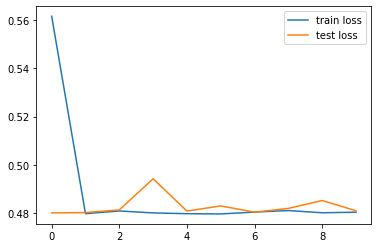

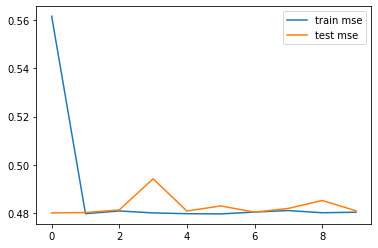

In [ ]:
r = model.fit(
  x=[df_train.userId.values, df_train.product_idx.values, tp_train],
  y=df_train.rating.values - mu,
  epochs=epochs,
  batch_size=128,
  validation_data=(
    [df_test.userId.values, df_test.product_idx.values, tp_test],
    df_test.rating.values - mu
  )
)


# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# plot mse
plt.plot(r.history['mean_squared_error'], label="train mse")
plt.plot(r.history['val_mean_squared_error'], label="test mse")
plt.legend()
plt.show()

In [ ]:
model.evaluate([df_test.userId.values, df_test.product_idx.values, tp_test], df_test.rating.values)

721/721 [==============================] - 1s 1ms/step - loss: 0.8489 - mean_squared_error: 0.8489


[0.8488882780075073, 0.8488882780075073]

In [ ]:
# from keras.utils import plot_model
# plot_model(model)